## 2022-10-2122 SN 2022vqz

Analysis by Luke

### Non-Standard Calibration

We are using a slightly non-standard but very clean calibration procedure which requires
the lights and the darks to have the same exposure duration (typically of order 30s),
and the flats and the biases to have the same exposure duration (typically 1s). The more standard, less clean
procedure involves "scaling" the darks.

In [1]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
observation_date = '2022-10-2425'
light_exposure = 30 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality
method = 'median'

In [3]:
data_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)

In [4]:
light_directory = os.path.join(data_directory, 'light')
dark_directory = os.path.join(data_directory, 'dark')
flat_directory = os.path.join(data_directory, 'flat')
bias_directory = os.path.join(data_directory, 'bias')

In [5]:
light_files = ImageFileCollection(light_directory).files_filtered(include_path='True')
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files = ImageFileCollection(flat_directory).files_filtered(include_path='True')
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

In [6]:
lights = [CCDData.read(file, unit=u.adu) for file in light_files]
darks = [CCDData.read(file, unit=u.adu) for file in dark_files]
flats = [CCDData.read(file, unit=u.adu) for file in flat_files]
biases = [CCDData.read(file, unit=u.adu) for file in bias_files]

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [7]:
master_dark = combine(darks, method=method)
master_flat = combine(flats, method=method)
master_bias = combine(biases, method=method)

In [8]:
lights_subtracted = [subtract_dark(light, master_dark, data_exposure=light_exposure, dark_exposure=dark_exposure, scale=False) for light in lights]
master_flat_subtracted = subtract_dark(master_flat, master_bias, data_exposure=flat_exposure, dark_exposure=bias_exposure, scale=False)

In [9]:
lights_calibrated = [flat_correct(l, master_flat_subtracted) for l in lights_subtracted]

/Users/Suess/opt/anaconda3/envs/transient/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/Suess/opt/anaconda3/envs/transient/lib/python3.9/site-packages/astropy/nddata/nduncertainty.py:684: RuntimeWarning: invalid value encountered in true_divide
  return from_variance((left + right + correlation_sign * corr) /


In [10]:
light = lights[0]

In [11]:
calibrated_light = lights_calibrated[0]

### Alignment

We are using a slightly non-standard but very clean calibration procedure which requires
the lights and the darks to have the same exposure duration (typically of order 30s),
and the flats and the biases to have the same exposure duration (typically 1s). The more standard, less clean
procedure involves "scaling" the darks.

In [12]:
import astroalign as aa

In [13]:
reference = lights_calibrated[0]

In [14]:
sources_aligned = [aa.register(s, reference, detection_sigma=3.0) for s in lights_calibrated]

In [15]:
source = lights_calibrated[1]

In [16]:
img_aligned, footprint = sources_aligned[1]

### Display the Images

Experiment with LogStretch (especially) or any other stretching routine in astropy.visualization that makes our images, especially our calibrated images, show a lot of detail.

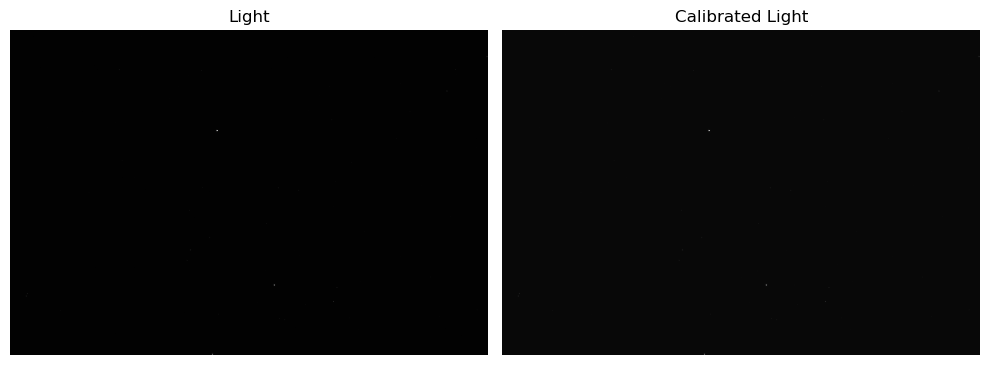

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(light, cmap='gray', interpolation='none', origin='lower')
axes[0].axis('off')
axes[0].set_title("Light")

axes[1].imshow(calibrated_light, cmap='gray', interpolation='none', origin='lower')
axes[1].axis('off')
axes[1].set_title("Calibrated Light")


plt.tight_layout()
plt.show()

### Display the Aligned Images

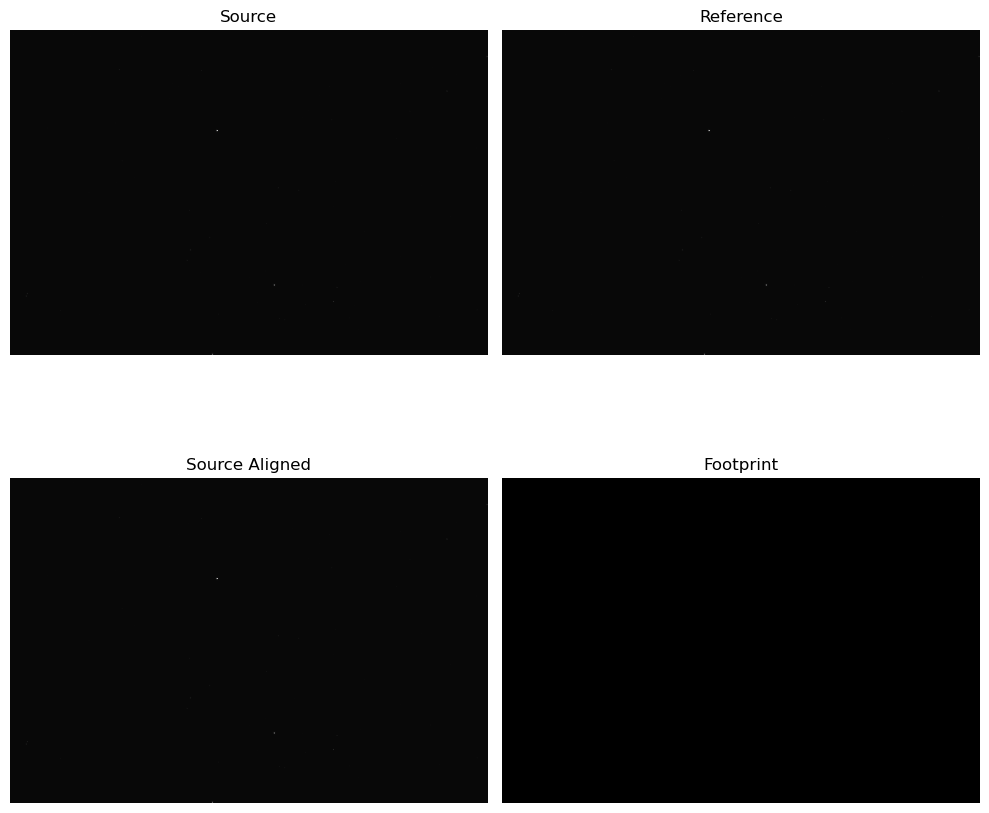

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(source, cmap='gray', interpolation='none', origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source")

axes[0, 1].imshow(reference, cmap='gray', interpolation='none', origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Reference")

axes[1, 0].imshow(img_aligned, cmap='gray', interpolation='none', origin='lower')
axes[1, 0].axis('off')
axes[1, 0].set_title("Source Aligned")

axes[1, 1].imshow(footprint, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Footprint")

plt.tight_layout()
plt.show()

### Visualization Stretching

In [69]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.visualization import (MinMaxInterval, LogStretch, SinhStretch, LinearStretch,
                                   ImageNormalize)


In [70]:
# Import aligned image
image = img_aligned

In [71]:
# Create interval object
#interval = MinMaxInterval()
vmin, vmax = interval.get_limits(image)

In [95]:
# Create an ImageNormalize object using a LogStretch object
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())


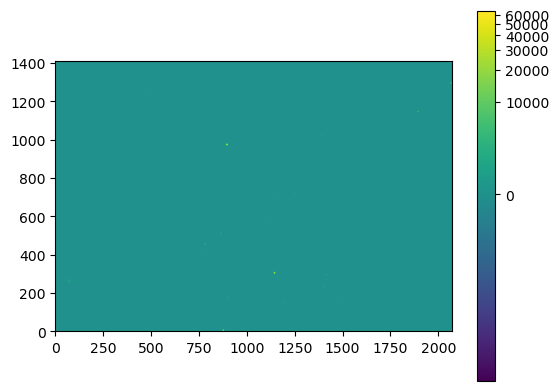

In [96]:
# Display the image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(image, origin='lower', norm=norm)
fig.colorbar(im)